# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

## Подготовка данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from phik import phik_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

RANDOM_STATE = 12345

In [3]:
#прочитаем датасет
df = pd.read_csv('/datasets/autos.csv')

#выведем первые 10 строк
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
#выведем общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
#удалим ненужные столбцы, которые не особо влияют на обучение моделей
df_clean = df.drop(['PostalCode', 'LastSeen', 'DateCreated', 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures'], axis=1)

In [6]:
#приведем название столбцов в соответствии с PEP 8
df_clean = df_clean.rename(columns=str.lower)
df_clean = df_clean.rename(columns={'datecrawled':'date_crawled', 
                   'vehicletype':'vehicle_type', 
                   'registrationyear':'registration_year', 
                   'registrationmonth':'registration_month',
                   'fueltype':'fuel_type',
                   'numberofpictures':'number_of_pictures'})

#выведем посмотреть первые 5 строк
df_clean.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [7]:
#посмотрим на количество пропусков в предоставленных данных
df_clean.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [8]:
#посмотрим на количество пропусков в предоставленных данных в процентном соотношении к общему количеству
for column in df_clean.isna().sum().index:
    if df_clean[column].isna().sum() != 0:
        print(f"Пропусков в {column}: {df_clean[column].isna().mean():.2%}")
    else:
        print("")


Пропусков в vehicle_type: 10.58%

Пропусков в gearbox: 5.60%

Пропусков в model: 5.56%

Пропусков в fuel_type: 9.28%

Пропусков в repaired: 20.08%


Заполнить модель в пропущенных значениях столбца `model` не представляется возможным, т.к. возможно пользователи резмещая объявления попросту могли не указывать модель. Также данные пропуски могут быть системными сбоями при выгрузке данных. Удалим данные пропуски ввиду малого количества (5.56%).

In [9]:
df_clean.dropna(subset=['model'], inplace=True)

#проверяем оставшееся количество пропусков
df_clean.isna().sum()

price                    0
vehicle_type         30662
registration_year        0
gearbox              15702
power                    0
model                    0
kilometer                0
fuel_type            25732
brand                    0
repaired             62100
dtype: int64

Пропуски в категориальных признаках, таких как `vehicle_type`, `gearbox`, `fuel_type` заменим модой по признаку `model`, а пропуски в столбце `repaired` заменим на занчение `yes`, т.к. в большинстве случаев поддержанные автомобили были в ремонте.

In [10]:
df_clean['vehicle_type'] = df_clean.groupby('model')['vehicle_type'].apply(lambda x: x.fillna(x.mode().iloc[0]))
df_clean['gearbox'] = df_clean.groupby('model')['gearbox'].apply(lambda x: x.fillna(x.mode().iloc[0]))
df_clean['fuel_type'] = df_clean.groupby('model')['fuel_type'].apply(lambda x: x.fillna(x.mode().iloc[0]))
df_clean['repaired'] = df_clean['repaired'].fillna('yes')

#проверим, что пропусков не осталось
df_clean.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Проверим категориальные признаки на наличие неявных дубликатов

In [11]:
df_clean['brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'porsche', 'rover', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

In [12]:
df_clean['vehicle_type'].unique()

array(['sedan', 'suv', 'small', 'convertible', 'bus', 'wagon', 'coupe',
       'other'], dtype=object)

In [13]:
df_clean['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [14]:
unique_values = df_clean['model'].unique()
sorted_values = np.sort(unique_values)
for value in sorted_values:
    print(value)

100
145
147
156
159
1_reihe
1er
200
2_reihe
300c
3_reihe
3er
4_reihe
500
5_reihe
5er
601
6_reihe
6er
7er
80
850
90
900
9000
911
a1
a2
a3
a4
a5
a6
a8
a_klasse
accord
agila
alhambra
almera
altea
amarok
antara
arosa
astra
auris
avensis
aveo
aygo
b_klasse
b_max
beetle
berlingo
bora
boxster
bravo
c1
c2
c3
c4
c5
c_klasse
c_max
c_reihe
caddy
calibra
captiva
carisma
carnival
cayenne
cc
ceed
charade
cherokee
citigo
civic
cl
clio
clk
clubman
colt
combo
cooper
cordoba
corolla
corsa
cr_reihe
croma
crossfire
cuore
cx_reihe
defender
delta
discovery
doblo
ducato
duster
e_klasse
elefantino
eos
escort
espace
exeo
fabia
fiesta
focus
forester
forfour
fortwo
fox
freelander
fusion
g_klasse
galant
galaxy
getz
gl
glk
golf
grand
i3
i_reihe
ibiza
impreza
insignia
jazz
jetta
jimny
juke
justy
ka
kadett
kaefer
kalina
kalos
kangoo
kappa
kuga
laguna
lancer
lanos
legacy
leon
lodgy
logan
lupo
lybra
m_klasse
m_reihe
materia
matiz
megane
meriva
micra
mii
modus
mondeo
move
musa
mustang
mx_reihe
navara
niva
note
nubira
o

Заменим `rangerover` на `range_rover`

In [15]:
df_clean['model'] = df_clean['model'].replace('rangerover','range_rover')

In [16]:
df_clean['fuel_type'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Неявных дубликатов в категориальных признаках не обнаружилось

Посмотрим на описание числовых признаков

In [17]:
df_clean.describe()

,price,registration_year,power,kilometer
count,334664.000000,334664.000000,334664.000000,334664.000000
mean,4504.346790,2003.923992,111.373195,128562.588148
std,4531.438572,69.377219,185.156439,37205.926976
min,0.000000,1000.000000,0.000000,5000.000000
25%,1150.000000,1999.000000,70.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Смотрим столбец `price`

In [18]:
#смотрим количество нулевых значений
len(df_clean.query('price == 0'))

8588

Количество нулевых значений составляет меньше 5%, поэтому удалим их

In [19]:
df_clean = df_clean.query('price > 0')

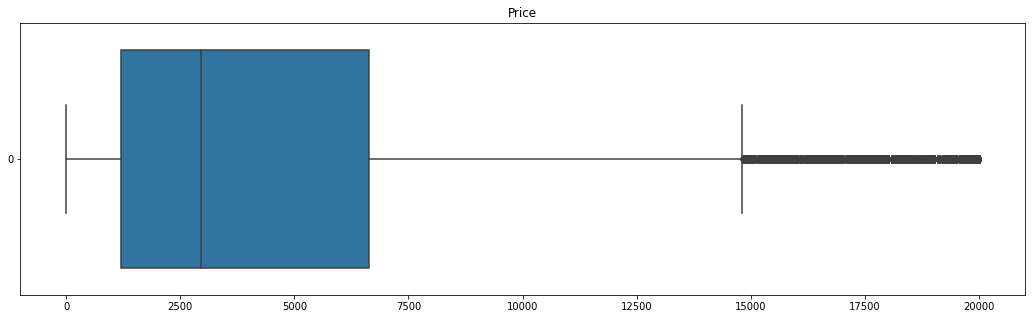

In [20]:
c

Смотрим столбец с годом регистрации

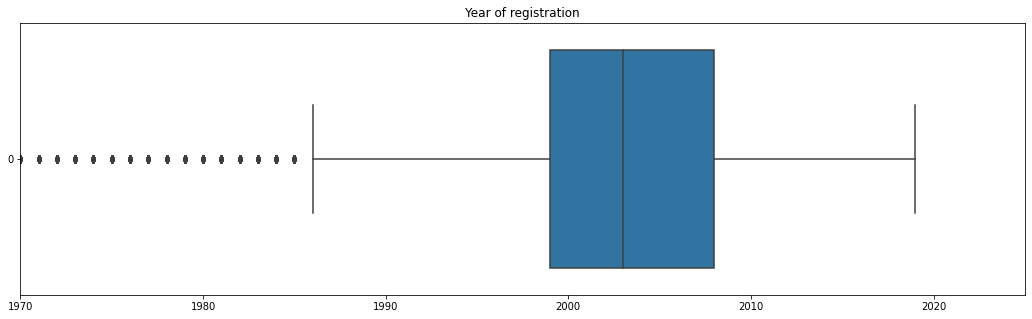

In [21]:
plt.figure(figsize=(18,5))
plt.xlim(1970, 2025) 
sns.boxplot(data=df_clean.registration_year, orient='h')
plt.title('Year of registration')
plt.show()

In [22]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

Больше 30 лет считаем авто за раритет, а самая поздняя дата выгрузки анкеты - это 2016-ый год. В связи с этим возьмем 30-летний период 1986-2016 гг. отбросив все остальные.

In [23]:
df_clean = df_clean.query('1986 <= registration_year < 2017')

Смотрим столбец с мощностью

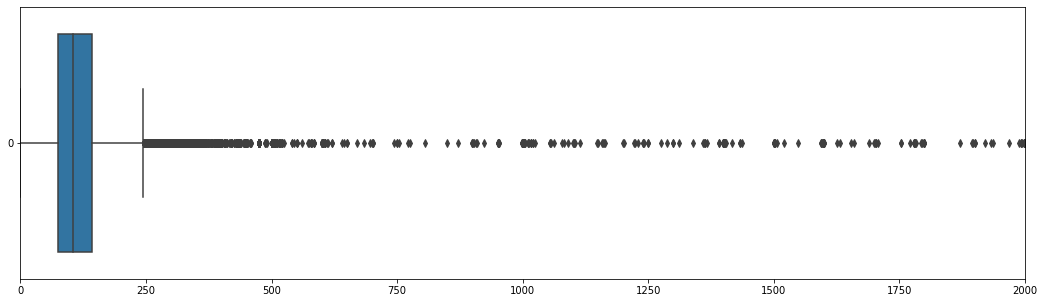

In [24]:
plt.figure(figsize=(18,5))
plt.xlim(0, 2000) 
sns.boxplot(data=df_clean.power, orient='h')
plt.show()

In [25]:
len(df_clean.query('power == 0'))

27414

На 2016 год самое мощное авто имеет мощность 1500 лошадиных сил. В связи с этой информацией посмотрим сколько у нас позиций выше этой мощности.

In [26]:
len(df_clean.query('power > 1500'))

153

Всего 153 позиции, поэтому удалим их

In [27]:
df_clean = df_clean.query('power <= 1500')

Пропуски в мощности заменим медианой по модели авто

In [28]:
# Расчет медианы по столбцу "мощность авто" для каждой модели авто
median_power = df_clean.groupby('model')['power'].median()

# Заполнение нулевых значений медианой по столбцу "модель авто"
df_clean['power'] = df_clean.groupby('model')['power'].transform(lambda x: x.replace(0, median_power[x.name]))

Посмотрим остались ли нулевые позиции по мощности. Если остались,то значит по этой модели авто все позиции нулевые и мы тогда возьмем данные без этой модели авто.

In [29]:
df_clean.query('power == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
3338,199,sedan,1995,manual,0.0,samara,100000,petrol,lada,yes
26625,200,sedan,2016,manual,0.0,samara,150000,petrol,lada,yes
42665,300,small,1997,manual,0.0,samara,50000,petrol,lada,yes
69358,99,sedan,1995,manual,0.0,samara,125000,petrol,lada,yes
150050,650,wagon,2007,manual,0.0,samara,125000,petrol,lada,yes
353555,2199,sedan,2016,manual,0.0,samara,70000,petrol,lada,no


In [30]:
df_clean = df_clean.query('power != 0')

Посмотрим на боксплот столбца с пробегом

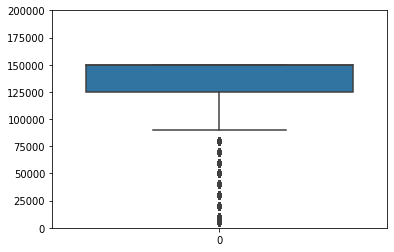

In [31]:
plt.ylim(0, 200000) 
sns.boxplot(data=df_clean.kilometer)
plt.show()

Никаких аномалий по столбцу с пробегом не выявлено

Построим хитмэп фик-матрицы признаков, т.к. данная матрица показывает корреляцию между переменными, которая учитывает не только линейную связь между ними, но и связь нелинейную и категориальную. Матрица была разработана для оценки степени взаимосвязи между переменными в дискретных или смешанных наборах данных, где переменные могут быть категориальными, бинарными или числовыми.

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


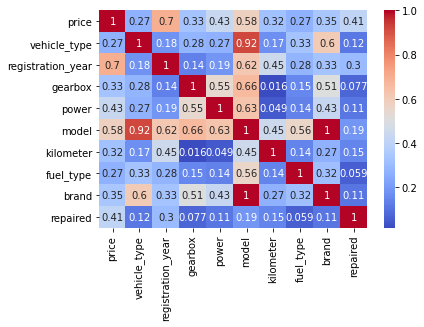

In [32]:
ph_matrix = phik_matrix(df_clean)
sns.heatmap(ph_matrix, cmap='coolwarm', annot=True)
plt.show()

Автоматически метод phik-matrix правильно определил категориальные и числовые признаки. Корреляция со значением "1" между признаками модель и бренд. Это связано с тем, что не может быть одной и той же модели у разных брендов. Также высокая корреляция между моделью авто и типом кузова, что в принципе объясняется тем, что чаще всего у модели один тип кузова.

Вывод: по итогам преобработки избавились от признаков, которые никак не влияют на на целевой признак, заполнили пропуски, убрали аномалии.

## Обучение моделей

Обучать будем три модели: линейную регрессию, CatBoost, LightGBM. Для моделей линейной регрессии и LGBM данные будут предобработаны методами OHE и StandardScaler, поэтому для обучения этих моделей для предобработки данных возьмем копию датафрейма. Для CatBoost предобрабатывать данные не будем - возьмем первоначальный датафрейм.

In [33]:
#скопируем предобработанный датафрейм
df_ohe = df_clean.copy()
df_oe = df_clean.copy()

#применим OHE ко всему датафрейму
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

#посмотрим на первые 5 строк преобразованного датафрейма
df_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
0,480,1993,101.0,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1500,2001,75.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69.0,90000,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,102.0,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
#выделим признаки и целевой признак первоначального датафрейма
features = df_clean.drop(['price'], axis=1)
target = df_clean['price']

#разобьем признаки и целевой признак на 2 группы, отделив обучающие данные от тестовых + валидационных
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE)

#затем разобьем вторую группу пополам: одни данные будут валидационными, другие - тестовыми 
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.50, random_state=RANDOM_STATE)

#проверим
display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)
display(target_train.shape)
display(target_valid.shape)
display(target_test.shape)

(185680, 9)

(61893, 9)

(61894, 9)

(185680,)

(61893,)

(61894,)

In [35]:
#выделим признаки и целевой признак копии датафрейма и уже в котором категориальные данные обработаны методом OHE
features_ohe = df_ohe.drop(['price'], axis=1)
target_ohe = df_ohe['price']

#разобьем признаки и целевой признак на 2 группы, отделив обучающие данные от тестовых + валидационных
features_train_ohe, features_valid_test_ohe, target_train_ohe, target_valid_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.40, random_state=RANDOM_STATE)

#затем разобьем вторую группу пополам: одни данные будут валидационными, другие - тестовыми 
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(
    features_valid_test_ohe, target_valid_test_ohe, test_size=0.50, random_state=RANDOM_STATE)

#проверим
display(features_train_ohe.shape)
display(features_valid_ohe.shape)
display(features_test_ohe.shape)
display(target_train_ohe.shape)
display(target_valid_ohe.shape)
display(target_test_ohe.shape)

(185680, 301)

(61893, 301)

(61894, 301)

(185680,)

(61893,)

(61894,)

In [36]:
#выделим признаки и целевой признак первоначального датафрейма
features_oe = df_oe.drop(['price'], axis=1)
target_oe = df_oe['price']

#разобьем признаки и целевой признак на 2 группы, отделив обучающие данные от тестовых + валидационных
features_train_oe, features_valid_test_oe, target_train_oe, target_valid_test_oe = train_test_split(
    features_oe, target_oe, test_size=0.40, random_state=RANDOM_STATE)

#затем разобьем вторую группу пополам: одни данные будут валидационными, другие - тестовыми 
features_valid_oe, features_test_oe, target_valid_oe, target_test_oe = train_test_split(
    features_valid_test_oe, target_valid_test_oe, test_size=0.50, random_state=RANDOM_STATE)

#проверим
display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)
display(target_train.shape)
display(target_valid.shape)
display(target_test.shape)

(185680, 9)

(61893, 9)

(61894, 9)

(185680,)

(61893,)

(61894,)

Далее масштабируем признаки методом стандартизации (StandardScaler) для данных OHE

In [37]:
#сохраним в переменную названия столбцов имеющих численные данные
num_cols = ['registration_year', 'power', 'kilometer']
cat_cols = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

#cоздадим объект и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train_ohe[num_cols])

pd.options.mode.chained_assignment = None

features_train_ohe[num_cols] = scaler.transform(features_train_ohe[num_cols])
features_valid_ohe[num_cols] = scaler.transform(features_valid_ohe[num_cols])
features_test_ohe[num_cols] = scaler.transform(features_test_ohe[num_cols])

Тоже самое, но для данных OE

In [38]:
#сохраним в переменную названия столбцов имеющих численные данные
num_cols = ['registration_year', 'power', 'kilometer']
cat_cols = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

#настроим его на обучающих данных
scaler.fit(features_train_oe[num_cols])

features_train_oe[num_cols] = scaler.transform(features_train_oe[num_cols])
features_valid_oe[num_cols] = scaler.transform(features_valid_oe[num_cols])
features_test_oe[num_cols] = scaler.transform(features_test_oe[num_cols])

Обучаем линейную регрессию. Везде на обучении и предсказаниях моделей будем замерять время для анализа и выбора лучшей модели

In [39]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 11.5 s, sys: 4.03 s, total: 15.5 s
Wall time: 15.4 s


LinearRegression()

Получаем предсказания на валидационных данных

In [40]:
%%time

predict_lr_ohe = model_lr.predict(features_valid_ohe)

CPU times: user 90.8 ms, sys: 44.6 ms, total: 135 ms
Wall time: 123 ms


Считаем RMSE для линейной регрессии

In [54]:
rmse_lr = mse(target_valid_ohe, predict_lr_ohe, squared=False)
rmse_lr

2541.0622573317064

Применим OrdinalEncoding

In [42]:
# Создание экземпляра класса OrdinalEncoder
encoder = OrdinalEncoder()

#объеденим выборки (трэйн + валид + тест)
features_united_oe = pd.concat([features_train_oe, features_valid_oe, features_test_oe])

#фитуем на объединенных данных
encoder.fit(features_united_oe[cat_cols])

#применим метод transform на тренировочных, валидационных и тестовых данных
features_train_oe[cat_cols] = encoder.transform(features_train_oe[cat_cols])
features_valid_oe[cat_cols] = encoder.transform(features_valid_oe[cat_cols])
features_test_oe[cat_cols] = encoder.transform(features_test_oe[cat_cols])



Обучаем первую модель градиентного бустинга - CatBoost. Воспользуемся встроенным grid_search в CatBoost и поперебираем коэффициент обучения с 0.1 до 1.0 с шагом 0.2. Обучение проведем на некодированных данных методами OHE или OE. 

In [43]:
%%time

model_cbr = CatBoostRegressor(loss_function='RMSE')
parameters = {'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = model_cbr.grid_search(parameters,
            Pool(features_train, target_train, cat_features=cat_cols),
            cv=3,
            verbose=1000)

0:	learn: 5941.1286155	test: 5997.1903348	best: 5997.1903348 (0)	total: 257ms	remaining: 4m 17s
1:	learn: 5454.8215160	test: 5502.4744837	best: 5502.4744837 (1)	total: 386ms	remaining: 3m 12s
2:	learn: 5021.8176759	test: 5062.8580799	best: 5062.8580799 (2)	total: 496ms	remaining: 2m 44s
3:	learn: 4638.5310947	test: 4674.2758539	best: 4674.2758539 (3)	total: 636ms	remaining: 2m 38s
4:	learn: 4289.4479317	test: 4321.5930294	best: 4321.5930294 (4)	total: 768ms	remaining: 2m 32s
5:	learn: 3989.7794147	test: 4015.8693153	best: 4015.8693153 (5)	total: 882ms	remaining: 2m 26s
6:	learn: 3723.5743794	test: 3745.9443096	best: 3745.9443096 (6)	total: 999ms	remaining: 2m 21s
7:	learn: 3492.4124307	test: 3512.2866803	best: 3512.2866803 (7)	total: 1.16s	remaining: 2m 24s
8:	learn: 3284.2436817	test: 3300.9015821	best: 3300.9015821 (8)	total: 1.27s	remaining: 2m 20s
9:	learn: 3102.5878946	test: 3117.5540724	best: 3117.5540724 (9)	total: 1.39s	remaining: 2m 17s
10:	learn: 2943.0713597	test: 2955.60368

In [44]:
#оптимальный коэффициент обучения
catboost_grid["params"]

{'learning_rate': 0.30000000000000004}

In [45]:
%%time

#подставим оптимальный коэффициент и обучим
model_cbr = CatBoostRegressor(learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
model_cbr.fit(Pool(features_train, target_train, cat_features=cat_cols))

0:	learn: 3632.7090676	total: 166ms	remaining: 2m 45s
100:	learn: 1619.3844021	total: 17s	remaining: 2m 31s
200:	learn: 1559.8336855	total: 32.2s	remaining: 2m 8s
300:	learn: 1522.5370050	total: 48.1s	remaining: 1m 51s
400:	learn: 1497.0181531	total: 1m 3s	remaining: 1m 35s
500:	learn: 1477.4033339	total: 1m 19s	remaining: 1m 18s
600:	learn: 1459.6840713	total: 1m 35s	remaining: 1m 3s
700:	learn: 1444.1244765	total: 1m 51s	remaining: 47.7s
800:	learn: 1430.2481751	total: 2m 8s	remaining: 31.9s
900:	learn: 1419.0409332	total: 2m 23s	remaining: 15.8s
999:	learn: 1408.7341711	total: 2m 39s	remaining: 0us
CPU times: user 2min 40s, sys: 509 ms, total: 2min 40s
Wall time: 2min 42s


Получим предсказания по CatBoost

In [46]:
%%time

predict_cbr = model_cbr.predict(features_valid)

CPU times: user 715 ms, sys: 41 µs, total: 715 ms
Wall time: 719 ms


Рассчитаем RMSE по CatBoost

In [47]:
rmse_cbr = mse(target_valid, predict_cbr, squared=False)
rmse_cbr

1544.2376134196502

Обучим модель LightGBM с помощью GridSearch и найдем оптимальные параметры коэффициента обучения, количества "листьев" и количества "деревьев"

In [48]:
%%time

model_lgbm_oe = LGBMRegressor() 
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.1, 0.05, 0.01]
}
grid_search_oe = GridSearchCV(model_lgbm_oe, param_grid, cv=3)
grid_search_oe.fit(features_train_oe, target_train_oe)
print(grid_search_oe.best_params_)

{'learning_rate': 0.1, 'num_leaves': 30}
CPU times: user 9min 19s, sys: 3.31 s, total: 9min 22s
Wall time: 9min 26s


Определив оптимальные параметры обучим модель

In [53]:
%%time

model_lgbm_oe = LGBMRegressor(learning_rate=.1, num_leaves=30)
model_lgbm_oe.fit(features_train_oe, target_train_oe)

CPU times: user 30.5 s, sys: 171 ms, total: 30.6 s
Wall time: 30.8 s


LGBMRegressor(num_leaves=30)

Получим предсказания по LGBM

In [50]:
%%time

predict_lgbm_oe = model_lgbm_oe.predict(features_valid_oe)

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.18 s


Рассчитаем RMSE по LGBM

In [51]:
rmse_lgbm_oe = mse(target_valid_oe, predict_lgbm_oe, squared=False)
display(rmse_lgbm_oe)

1584.849916901055

## Анализ моделей

Сведем в датафрейм по всем моделям: RMSE, время обучения и время предсказания

In [59]:
index=['Линейная регрессия с OHE', 'CatBoost', 'LightGBM с OE']
data={'RMSE': [rmse_lr, rmse_cbr, rmse_lgbm_oe],
     'Время обучения':[19.7, 162, 30.8],
     'Время предсказания':[0.191, 0.719, 1.18]}
analyze = pd.DataFrame(data=data, index=index)
analyze

,RMSE,Время обучения,Время предсказания
Линейная регрессия с OHE,2541.062257,19.7,0.191
CatBoost,1544.237613,143.0,0.664
LightGBM с OE,1584.849917,10.9,1.340


RMSE линейной регрессии выше значения заданного условием  - 2500, поэтому, не думая, отбрасываем данную модель. По моделям градиентного бустинга: у CatBoost  - 1560, а у LGBM - 1597. Разница незначительна, но время обучения у CatBoost в разы больше, чем у LGBM, поэтому выберем, как лучшую модель -  модель LGBM и обучим ее на тестовой выборке.

In [61]:
#получаем предсказание на тестовых данных
test_predict_lgbm = model_lgbm_oe.predict(features_test_oe)

In [62]:
rmse_lgbm = mse(target_test_oe, test_predict_lgbm, squared=False)
rmse_lgbm

1656.7729813587175

## Вывод

1. Были загружены и предобработаны данные (очистка, заполнение, удаление лишних данных и т.д.)
2. Обучили на трейне и валидационных выборках 3 модели (две модели градиентного бустинга + линейная регрессия) и сравнили между собой
3. Выбрали лучшую модель по 3 показателям - RMSE, время обучения и время предскзания - и проверили ее на тестовой выборке.


Итого: наилучшей моделью стала LGBM, которая на финальном тестировании показала RMSE 1656.